<br>
<p style="font-size: 45px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: bold;
          line-height: 50px;"> Detección de Suciedad en Paneles Solares</p>
          
<p style="font-size: 20px;
          text-align:center;
          font-family: 'Times New Roman';
          font-variant: small-caps;
          font-weight: italic;
          line-height: 50px;">Parte 2: Extracción de Características - Reconocimiento de Patrones</p>


<br>
<div style="text-align: justify;width:85%;margin: 0 auto"> 
En el notebook anterior, se logró determinar la presencia o ausencia de suciedad en los paneles solares. Adicionalmente, se logró tener una clasificación entre ambos tipos de suciedad (blanco y café) presentes en el dataset, a continuación se realiza un proceso para determinar la prioridad de mantenimiento conociendo previamente que el panel se encuentra sucio.
</div>
<img src="res/Arquitectura_2.JPG" width=700>
<p style="text-align: center">Figura. Modelo propuesto para determinar la prioridad de mantenimiento de los paneles solares.</p>

<br>
<br>
<div style="text-align: justify;width:85%;margin: 0 auto"> 
Se procede a encontrar los descriptores de la imagen, basados en indicadores de textura, color, área, entre otros. Para el dataset de imágenes con presencia de suciedad.
</div>

# Importar datos de la segmentación

<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Se leen los datos del dataset creado con la suciedad segmentada. (carpeta:  'datasets/Soiling_data_output')
</div>

<img src="res/dataset_suciedad.JPG" width=700>
<p style="text-align: center">Figura. Dataset con segmentación de suciedad.</p>

<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Estos datos son generados en el primer notebook correspondiente a la parte de segmentación y están etiquetados con el tipo de suciedad, el porcentaje de área de esta y el porcentaje de la medición de pérdida de potencia.
</div>

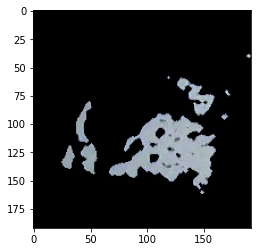

In [1]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Se define la ubicación actual del código con la librería Path
cwd = Path.cwd()

# Se declara la ubicación del dataset en cuestion
DATA_PATH_SOILING = cwd / 'datasets' / 'Soiling_data_output'

# Se retornan todos los nombres de las imagenes .jpg en una lista
paneles_sucios = list(DATA_PATH_SOILING.glob('*.jpg'))

# Se organizan de forma aleatoria los datos del dataset
np.random.seed(0)
np.random.shuffle(paneles_sucios )

# Se presenta una imagen del dataset de segmentación
img = plt.imread(paneles_sucios[-5])
plt.imshow(img)

# Se recupera la máscara de segmentación.

Dado que al guardar la imagen se perdió la variable de mascara, esta se recupera ubicando los pixeles negros de la imagen.



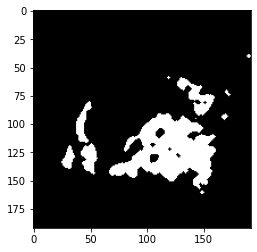

In [2]:
def return_mask(img):
    #Funcion para retornar mascara de la suciedad usando los pixeles que superan cierto umbral
    return (  (img[:,:,0]>8)
             &(img[:,:,0]>8)
             &(img[:,:,0]>8) )*255

# Se ejecuta la funcion
mask=return_mask(img)
# Se muestra la mascara
plt.imshow(mask,cmap='gray')

# Extracción de características

Dado un objeto en cuestión, se requiere obtener las características numéricas y categóricas de este. En el caso de este proyecto se desea encontrar aquellas variables que permitan describir el panel solar bajo análisis.

## Retornar información del etiquetado de la imagen

En el paso de segmentación se encontró el área de la imagen y se adjuntó al etiquetado de la misma, por lo cual se crea una función para retornar dicho valor, y el dato de la medición de perdida de potencia en el panel

In [3]:
# Se crea el diccionario para almacenar la información
features={}

def get_label_features(img_name,features):
    # Del nombre de la imagen se extrae la información del area.
    features['Area_Per']=str(img_name).split('_')[-1][:-4]
    
    # Del nombre de la imagen se extrae la información de la pérdida en potencia eléctrica.
    features['PowerLoss']=str(img_name).split('_')[-3]
    
    return features


In [4]:
# Se ejecuta la función creada.
features = get_label_features(paneles_sucios[-5],features)
features

{'Area_Per': '0.24218', 'PowerLoss': '0.844202988023'}

## Descriptores de textura

<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Se utilizan diferentes descriptores de textura para los espacios de color RGB - CMY - LAB, concretamente se utilizó el espacio C del CMY, los espacios correspondientes al verde y azul del RGB, y el espacio B del LAB. Inicialmente se toma la media de cada canal con su correspondiente desviación estándar, adicionalmente se utiliza el apuntamiento o kurtosis para tener información sobre la distribución del histograma entre la parte central y los extremos. Y finalmente, se utiliza el skew el cual suministra información acerca de la asimetría del histograma.
</div>

<img src="res/skew_kurtosis.JPG" width=650>
<p style="text-align: center">Figura.Descriptores de textura: Skew vs Kurtosis</p>



In [5]:
from scipy.stats import skew,kurtosis

def get_rgb_features(img,mask,features):  
    # Se ejecutan los algoritmos de promedio-std-kurtosis-skew sobre cada espacio de color.
    
    features['C_CMY_mean']=np.mean(255-img[(mask>100),0])
    features['C_CMY_std']=np.std(255-img[(mask>100),0])
    features['C_CMY_kurtosis'] = kurtosis(255-img[(mask>100),0])
    features['C_CMY_skew'] = skew(255-img[(mask>100),0])

    features['Green_mean']=np.mean(img[(mask>100),1])
    features['Green_std']=np.std(img[(mask>100),1])
    features['Green_kurtosis'] = kurtosis(img[(mask>100),1])
    features['Green_skew'] = skew(img[(mask>100),1])

    features['Blue_mean']=np.mean(img[(mask>100),2])
    features['Blue_std']=np.std(img[(mask>100),2])
    features['Blue_kurtosis'] = kurtosis(img[(mask>100),2])
    features['Blue_skew'] = skew(img[(mask>100),2])
    
    img_B_LAB=cv2.cvtColor(img,cv2.COLOR_RGB2LAB)[:,:,2]
    
    
    features['B_LAB_mean']=np.mean(img_B_LAB[(mask>100)])
    features['B_LAB_std']=np.std(img_B_LAB[(mask>100)])
    features['B_LAB_kurtosis'] = kurtosis(img_B_LAB[(mask>100)])
    features['B_LAB_skew'] = skew(img_B_LAB[(mask>100)])
    
    
    return features

In [6]:
# Se ejecuta la función creada para la imagen de prueba, y se presentan los resultados
features = get_rgb_features(img,mask,features)
features

{'Area_Per': '0.24218',
 'PowerLoss': '0.844202988023',
 'C_CMY_mean': 94.37931828650392,
 'C_CMY_std': 17.03205219915449,
 'C_CMY_kurtosis': 6.20516572296075,
 'C_CMY_skew': 1.8735651519525676,
 'Green_mean': 172.44518654997697,
 'Green_std': 17.50965026017764,
 'Green_kurtosis': 6.8277614596484035,
 'Green_skew': -2.0198226313427705,
 'Blue_mean': 183.97005988023952,
 'Blue_std': 18.659141028978205,
 'Blue_kurtosis': 6.0975773483874605,
 'Blue_skew': -1.7762352281497682,
 'B_LAB_mean': 120.70865960386918,
 'B_LAB_std': 2.983389235572386,
 'B_LAB_kurtosis': 0.7145572815005332,
 'B_LAB_skew': -0.5755706420239729}

## Métodos estadísticos de segundo orden

<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Adicionalmente se agregan estadisticos de segundo orden utilizando las funciones implementadas en la librería "Skimage":
</div>
<br><br>
<div style="text-align: center;width:80%;margin: 0 auto"> 
Disimilaridad - Contraste - Homogeneidad - ASM - Energía - Correlación
</div><br>


In [7]:
from skimage.feature import greycomatrix, greycoprops

#Función de estadísticos de segundo orden
def get_glcm_features(img_rgb,features):
    
    img=cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)
    #Calcular el nivel co-ocurrente de gris
    glcm = greycomatrix(img, [1,2,3], [0], 256, symmetric=True, normed=True)
    #Calcular la disimilaridad, contraste, homogeneidad, ASM, energía y correlación, guardar esto en el diccionario
    #de features
    features['dissimilarity'] = greycoprops(glcm, 'dissimilarity')[0][0]
    features['contrast'] = greycoprops(glcm, 'contrast')[0][0]
    features['homogeneity'] =greycoprops(glcm, 'homogeneity')[0][0]
    features['ASM'] = greycoprops(glcm, 'ASM')[0][0]
    features['energy'] =greycoprops(glcm, 'energy')[0][0]
    features['correlation'] = greycoprops(glcm, 'correlation')[0][0]
    
    return features

features=get_glcm_features(img, features)
features

{'Area_Per': '0.24218',
 'PowerLoss': '0.844202988023',
 'C_CMY_mean': 94.37931828650392,
 'C_CMY_std': 17.03205219915449,
 'C_CMY_kurtosis': 6.20516572296075,
 'C_CMY_skew': 1.8735651519525676,
 'Green_mean': 172.44518654997697,
 'Green_std': 17.50965026017764,
 'Green_kurtosis': 6.8277614596484035,
 'Green_skew': -2.0198226313427705,
 'Blue_mean': 183.97005988023952,
 'Blue_std': 18.659141028978205,
 'Blue_kurtosis': 6.0975773483874605,
 'Blue_skew': -1.7762352281497682,
 'B_LAB_mean': 120.70865960386918,
 'B_LAB_std': 2.983389235572386,
 'B_LAB_kurtosis': 0.7145572815005332,
 'B_LAB_skew': -0.5755706420239729,
 'dissimilarity': 3.857248036649208,
 'contrast': 428.03422229493816,
 'homogeneity': 0.8366421376515389,
 'ASM': 0.5728673108191623,
 'energy': 0.7568799844223404,
 'correlation': 0.9298845237471995}

Se procede a almacenar los datos obtenidos es un dataframe de pandas.

In [8]:
import pandas as pd

# Se crea un dataset de pandas con los descriptores encontrados
df=pd.DataFrame(columns=features.keys())
# Se agregan los valores de features en el dataset creado
df=df.append(features,ignore_index=True)
# Se muestra el resultado
df

,Area_Per,PowerLoss,C_CMY_mean,C_CMY_std,C_CMY_kurtosis,C_CMY_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,...,B_LAB_mean,B_LAB_std,B_LAB_kurtosis,B_LAB_skew,dissimilarity,contrast,homogeneity,ASM,energy,correlation
0,0.24218,0.844202988023,94.379318,17.032052,6.205166,1.873565,172.445187,17.50965,6.827761,-2.019823,...,120.70866,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.75688,0.929885


<br>
A continuación, se ejecuta el proceso presentado para todas las imágenes del dataset
<br>

In [9]:
for image_name in paneles_sucios:
    
    # Se lee la imagen
    img = plt.imread(str(image_name))
    
    # Se encuentra la mascara de la imagen
    mask = return_mask(img)
    
    # Se crea un diccionario vacio de descriptores
    features = {}
    
    # Se agregan al diccionario de descriptores los valores del label de cada imagen (Area de suciedad y potencia %)
    features = get_label_features(str(image_name),features)
    
    # Se agregan al diccionario de descriptores los valores de textura Mean-std-kurtosis-skew
    features = get_rgb_features(img,mask,features)
    
    # Se agregan al diccionario de descriptores de textura de segundo orden
    features=get_glcm_features(img, features)
    
    # Se hace el append con el dataframe general
    df = df.append(features,ignore_index=True)
    

Se guardan los descriptores obtenidos, y se presenta el resultado

In [10]:
# Guardar datos en un csv
df.to_csv('datasets/data.csv')
# Presentar el dataframe creado
df

,Area_Per,PowerLoss,C_CMY_mean,C_CMY_std,C_CMY_kurtosis,C_CMY_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,...,B_LAB_mean,B_LAB_std,B_LAB_kurtosis,B_LAB_skew,dissimilarity,contrast,homogeneity,ASM,energy,correlation
0,0.24218,0.844202988023,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
1,0.22092,0.658676864705,88.679607,29.955651,1.227137,1.112640,184.182758,32.090080,1.365387,-1.136582,...,117.003781,3.164467,1.028093,-0.082219,5.020697,545.749700,0.836837,0.588221,0.766956,0.916186
2,0.03141,0.188745245958,127.770833,34.444293,2.423503,0.194122,141.857639,34.724369,4.782616,-0.857277,...,112.289931,7.803198,-0.830144,0.009015,1.938591,224.456043,0.909665,0.649441,0.805879,0.651831
3,0.07437,0.845329524197,125.828486,20.224773,6.210698,1.470981,108.557047,14.274315,20.562415,-2.346366,...,136.792692,9.519569,-1.111979,0.177476,1.062936,87.779614,0.940044,0.807265,0.898479,0.904917
4,0.14572,0.14254153713,114.643731,20.876255,4.596895,-0.882647,149.259939,20.947247,6.207381,0.781776,...,117.092890,3.558297,0.122103,0.532742,4.371482,491.121428,0.857505,0.602837,0.776426,0.835520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,0.844202988023,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
583,0.06499,0.0302054414214,140.777591,30.769344,3.276176,-0.527426,134.667228,30.093138,6.540237,-0.742554,...,107.908172,7.987511,-0.169123,0.675195,2.516552,285.705252,0.907050,0.687397,0.829094,0.751809
584,0.23342,0.642704243533,89.344466,29.061491,1.401353,1.109943,183.663884,30.824591,1.877945,-1.171462,...,116.823950,3.398546,0.526434,0.019355,5.497491,616.462151,0.825034,0.556109,0.745727,0.909064
585,0.30868,0.650890198939,95.426744,36.156897,-0.475406,0.552524,178.249414,38.550435,-0.179933,-0.590162,...,115.714183,3.990905,0.580935,-0.259726,6.243183,609.551374,0.793218,0.505971,0.711316,0.926271


---

# Reconocimiento de patrones
<br>
<div style="text-align: justify;width:80%;margin: 0 auto"> 
Se procede a utilizar un algoritmo que permita establecer la prioridad de mantenimiento que tiene un panel bajo análisis. Para ello se utilizará un proceso de clasificación entre 3 posibles categorías <br>

* Prioridad Baja (Low)
* Prioridad Media (Medium)
* Prioridad Alta (High)

Sin embargo, se debe notar que la perdida de potencia que se tiene de cada imagen es una variable numérica, por lo cual se pasa a un tipo de variable categórica usando la función cut de pandas
</div>

In [11]:
import pandas as pd

# Se genera una copia del dataset General
df2=df.copy()

# Se pasa de variable numérica a variable categórica con la función cut
df2.loc[:,'PowerLoss']=pd.cut(
                                x = np.array(df['PowerLoss'],dtype=np.float32),
                                bins = 3,
                                labels = ["Low", "Medium", "High"]
                            )
# Se presenta el resultado
df2

,Area_Per,PowerLoss,C_CMY_mean,C_CMY_std,C_CMY_kurtosis,C_CMY_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,...,B_LAB_mean,B_LAB_std,B_LAB_kurtosis,B_LAB_skew,dissimilarity,contrast,homogeneity,ASM,energy,correlation
0,0.24218,High,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
1,0.22092,High,88.679607,29.955651,1.227137,1.112640,184.182758,32.090080,1.365387,-1.136582,...,117.003781,3.164467,1.028093,-0.082219,5.020697,545.749700,0.836837,0.588221,0.766956,0.916186
2,0.03141,Low,127.770833,34.444293,2.423503,0.194122,141.857639,34.724369,4.782616,-0.857277,...,112.289931,7.803198,-0.830144,0.009015,1.938591,224.456043,0.909665,0.649441,0.805879,0.651831
3,0.07437,High,125.828486,20.224773,6.210698,1.470981,108.557047,14.274315,20.562415,-2.346366,...,136.792692,9.519569,-1.111979,0.177476,1.062936,87.779614,0.940044,0.807265,0.898479,0.904917
4,0.14572,Low,114.643731,20.876255,4.596895,-0.882647,149.259939,20.947247,6.207381,0.781776,...,117.092890,3.558297,0.122103,0.532742,4.371482,491.121428,0.857505,0.602837,0.776426,0.835520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,High,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
583,0.06499,Low,140.777591,30.769344,3.276176,-0.527426,134.667228,30.093138,6.540237,-0.742554,...,107.908172,7.987511,-0.169123,0.675195,2.516552,285.705252,0.907050,0.687397,0.829094,0.751809
584,0.23342,Medium,89.344466,29.061491,1.401353,1.109943,183.663884,30.824591,1.877945,-1.171462,...,116.823950,3.398546,0.526434,0.019355,5.497491,616.462151,0.825034,0.556109,0.745727,0.909064
585,0.30868,High,95.426744,36.156897,-0.475406,0.552524,178.249414,38.550435,-0.179933,-0.590162,...,115.714183,3.990905,0.580935,-0.259726,6.243183,609.551374,0.793218,0.505971,0.711316,0.926271


## Definición de entradas y salidas
<br>
<div style="text-align: justify;width:90%;margin: 0 auto"> 
Para la tarea bajo estudio se requiere tener claro cuál es la salida deseada, en este caso es la prioridad de mantenimiento de un panel (Columna: "PowerLoss"), mientras que, las entradas para el sistema serán el area de la suciedad segmentada y los descriptores de textura presentados (Mean - std - Kurtosis - Skew)
</div>
<br>

A continuación, se separan las entradas de las salidas, para las entradas se tiene:

In [12]:
# Se definen las entradas (X) tomando todas las columnas menos PowerLoss
X_all=df2.loc[:, df2.columns != 'PowerLoss']
# Se presenta el resultado
X_all

,Area_Per,C_CMY_mean,C_CMY_std,C_CMY_kurtosis,C_CMY_skew,Green_mean,Green_std,Green_kurtosis,Green_skew,Blue_mean,...,B_LAB_mean,B_LAB_std,B_LAB_kurtosis,B_LAB_skew,dissimilarity,contrast,homogeneity,ASM,energy,correlation
0,0.24218,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,183.970060,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
1,0.22092,88.679607,29.955651,1.227137,1.112640,184.182758,32.090080,1.365387,-1.136582,201.856819,...,117.003781,3.164467,1.028093,-0.082219,5.020697,545.749700,0.836837,0.588221,0.766956,0.916186
2,0.03141,127.770833,34.444293,2.423503,0.194122,141.857639,34.724369,4.782616,-0.857277,168.597222,...,112.289931,7.803198,-0.830144,0.009015,1.938591,224.456043,0.909665,0.649441,0.805879,0.651831
3,0.07437,125.828486,20.224773,6.210698,1.470981,108.557047,14.274315,20.562415,-2.346366,98.353468,...,136.792692,9.519569,-1.111979,0.177476,1.062936,87.779614,0.940044,0.807265,0.898479,0.904917
4,0.14572,114.643731,20.876255,4.596895,-0.882647,149.259939,20.947247,6.207381,0.781776,168.063073,...,117.092890,3.558297,0.122103,0.532742,4.371482,491.121428,0.857505,0.602837,0.776426,0.835520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,0.24218,94.379318,17.032052,6.205166,1.873565,172.445187,17.509650,6.827761,-2.019823,183.970060,...,120.708660,2.983389,0.714557,-0.575571,3.857248,428.034222,0.836642,0.572867,0.756880,0.929885
583,0.06499,140.777591,30.769344,3.276176,-0.527426,134.667228,30.093138,6.540237,-0.742554,168.306655,...,107.908172,7.987511,-0.169123,0.675195,2.516552,285.705252,0.907050,0.687397,0.829094,0.751809
584,0.23342,89.344466,29.061491,1.401353,1.109943,183.663884,30.824591,1.877945,-1.171462,201.659351,...,116.823950,3.398546,0.526434,0.019355,5.497491,616.462151,0.825034,0.556109,0.745727,0.909064
585,0.30868,95.426744,36.156897,-0.475406,0.552524,178.249414,38.550435,-0.179933,-0.590162,198.108848,...,115.714183,3.990905,0.580935,-0.259726,6.243183,609.551374,0.793218,0.505971,0.711316,0.926271


Adicionalmente, se normalizan los datos con la función StandardScaler de sklearn.preprocessing, con el objetivo de que la magnitud de las variables no genere sesgos en el entrenamiento del modelo

In [13]:
from sklearn.preprocessing import StandardScaler
# Se carga el modelo para normalizar
scaler = StandardScaler()
# Se entrena el modelo con el .fit
scaler.fit(X_all)
# Se transforma la data inicial
X_all_norm=scaler.transform(X_all)

Y para la salida se toma la columna que contiene la información de las pérdidas en potencia como variable categórica:

In [14]:
# Se definen las salidas como la columna PowerLoss
Y_all=df2.loc[:,'PowerLoss']
# Se muestran los resultados
Y_all

0        High
1        High
2         Low
3        High
4         Low
        ...  
582      High
583       Low
584    Medium
585      High
586      High
Name: PowerLoss, Length: 587, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

## División de los datos en conjuntos de entrenamiento y validación
<br>
<div style="text-align: justify;width:85%;margin: 0 auto"> 
En este caso se utilizará un modelo de aprendizaje supervisado, por lo cual se requiere poner a pruebe el modelo generado con datos no usados durante la construcción de este. Con el objetivo de validar el comportamiento del modelo y buscar aquellos problemas que se puedan presentar.

Los datos en cuestión se dividirán en dos conjuntos:

* ***Train*** : Estos datos serán los utilizados en la etapa de entrenamiento
* ***Test*** : Estos datos serán utilizados en la etapa de validación para verificar la precisión del modelo construido.

El objetivo principal de hacer la división de datos es evitar que el modelo memorice las imágenes de entrenamiento, y logre generalizar el proceso de clasificación de prioridad de mantenimiento en los paneles solares.
</div><br>

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_all_norm, Y_all,test_size=0.25)

<br>
<div style="text-align: justify;width:85%;margin: 0 auto"> 
Observar que el argumento test_size corresponde al porcentaje de datos a utilizar para validación, es decir, en este caso se está utilizando un 25% de los datos para este fin, y el 75% restante se utiliza para el entrenamiento del modelo.
</div><br>

## Construcción del Modelo



Una vez se tiene la división entre los datos de entrenamiento y de prueba, se procede con la construcción del modelo usando los datos de entrenamiento

### Modelo propuesto (Support Vector Machine - SVM)

Para la tarea en cuestión, se propone hacer uso del algoritmo de máquinas de vectores de soporte (SVM) implementado en la librería sklearn

<img src="res/SVM.jpg" width=500>
<p style="text-align: center">Figura. Concepto del SVM (Suppor Vector Machine) </p>

In [16]:
from sklearn import svm

# Se crea el modelo del SVM
clf = svm.SVC()
# Se entrena el model del SVM
clf.fit(x_train,  y_train)

SVC()

## Evaluación de desempeño

Para probar el comportamiento del modelo entrenado se utiliza la función predict

In [17]:
y_pred = clf.predict(x_test)

In [21]:
y_pred

array(['Medium', 'High', 'High', 'High', 'High', 'High', 'Low', 'Low',
       'High', 'Low', 'High', 'Low', 'Low', 'High', 'High', 'High', 'Low',
       'Low', 'Low', 'Medium', 'Medium', 'Low', 'High', 'Low', 'High',
       'High', 'Low', 'High', 'High', 'High', 'Medium', 'Low', 'Low',
       'Low', 'Low', 'High', 'Medium', 'Medium', 'Low', 'Medium',
       'Medium', 'Medium', 'Low', 'High', 'Low', 'Low', 'Low', 'Low',
       'Low', 'Low', 'Low', 'Low', 'Low', 'Low', 'High', 'High', 'Low',
       'High', 'Low', 'High', 'Medium', 'Medium', 'High', 'Low', 'High',
       'Medium', 'Medium', 'High', 'Low', 'Low', 'High', 'Low', 'High',
       'Low', 'High', 'Medium', 'Medium', 'Medium', 'High', 'High', 'Low',
       'Medium', 'Medium', 'Medium', 'Low', 'Low', 'Low', 'High', 'Low',
       'High', 'High', 'High', 'Low', 'Low', 'Low', 'High', 'High', 'Low',
       'Medium', 'Low', 'Low', 'High', 'Low', 'High', 'High', 'Medium',
       'Medium', 'Medium', 'Low', 'Low', 'High', 'High', 'Low', '

In [22]:
y_test

53     Medium
351      High
223      High
434      High
513      High
        ...  
477      High
233      High
173      High
333    Medium
528       Low
Name: PowerLoss, Length: 147, dtype: category
Categories (3, object): ['Low' < 'Medium' < 'High']

Luego se obtiene el puntaje de precisión utilizando la librería metrics de sklearn.

In [18]:
from sklearn.metrics import confusion_matrix, precision_score
print(precision_score(y_test, y_pred, average='weighted'))

0.842880853124866


Para observar el comportamiento de los resultados obtenidos se realiza una matriz de confusión sobre los datos de prueba.

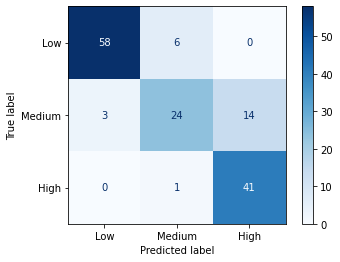

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt


plot_confusion_matrix(clf, x_test, y_test,
                      cmap=plt.cm.Blues,
                      labels=['Low','Medium','High'],
                      display_labels=['Low','Medium','High'])

Luego se ejectua la matriz de confusión sobre los datos de entrenamiento para verificar el comportamiento del modelo propuesto.

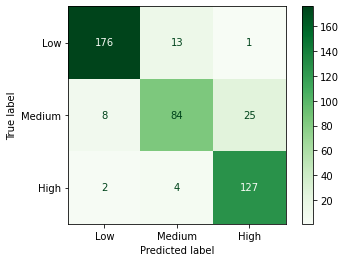

In [20]:
plot_confusion_matrix(clf, x_train, y_train,
                      cmap=plt.cm.Greens,
                      labels=['Low','Medium','High'],
                      display_labels=['Low','Medium','High'])


# Referencias 

<br>
<div style="text-align: justify;width:90%;margin: 0 auto"> 
[1]. CELSIA. "Todo lo que debes saber sobre energía solar en Colombia - Celsia - Eficiencia energética". Celsia - Eficiencia energética. https://eficienciaenergetica.celsia.com/todo-lo-que-debes-saber-sobre-energia-solar-en-colombia/ (accedido el 12 de agosto de 2021). <br><br>
[2] S. Mehta, A. P. Azad, S. A. Chemmengath, V. Raykar and S. Kalyanaraman, DeepSolarEye: Power Loss Prediction and Weakly Supervised Soiling Localization via Fully Convolutional Networks for Solar Panels," 2018 IEEE Winter Conference on Applications of Computer Vision (WACV), Lake Tahoe, NV, 2018, pp. 333-342. <br><br>
[3]. F. Rau Andrade, "ESTUDIO DEL EFECTO SOILING EN EL RENDIMIENTO DE PANELES SOLARES FOTOVOLTAICOS EN UNA ZONA RESIDENCIAL", Santiago de Chile, 2017. Disponible en: https://repositorio.usm.cl/bitstream/handle/11673/24673/3560902048979UTFSM.pdf?sequence=1&isAllowed=y <br><br>
[4]. K. Navarrete Cipriano, "“ Análisis técnico-económico de un sistema fotovoltaico con influencia de suciedad, viento y lluvia en ArequipaPerú ”", Arequipa, 2019. Disponible en: https://repositorio.utp.edu.pe/bitstream/handle/20.500.12867/2261/Karim%20Navarrete_Tesis_Titulo%20Profesional_2019.pdf?sequence=1&isAllowed=y <br><br>
[5]. Keim R, "UnUnderstanding Parametric Tests, Skewness, and Kurtosis - All about circuits", 2020. Disponible en: https://www.allaboutcircuits.com/technical-articles/understanding-the-normal-distribution-parametric-tests-skewness-and-kurtosis/
</div>